In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt

The goal of this is to compare different samples that taking into account each sample's scenario. In this case we use baseball batting average. Not every player plays the same number of games and each player bats in the different order, and each player is up-to-bat a different number of times. The goal is to still estimate the skill of all of the players even the ones with a relatively small number of batting opportunities

In [2]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t")
data.head()

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonHits,SeasonAverage
0,Roberto,Clemente,45,18,0.400,367,0.3460,412,145,0.352
1,Frank,Robinson,45,17,0.378,426,0.2981,471,144,0.306
2,Frank,Howard,45,16,0.356,521,0.2764,566,160,0.283
3,Jay,Johnstone,45,15,0.333,275,0.2218,320,76,0.238
4,Ken,Berry,45,14,0.311,418,0.2727,463,128,0.276


In [3]:
at_bats, hits = data[["At-Bats", "Hits"]].to_numpy().T

we introduce phi to account for the expected performance for all players. We don't know the mean and its bounded between 0 and 1. We assume that we don't know about global average as well. In this case we will have to draw from the uniform distribution

We also introduce kappa which will take into account the variance. For that we will use the Pareto distribution. This will ensure the estimated value falls within reasoonable bounds. Really this hyperparameter will be used to paremterize the beta distribution. 

Then the final step is to specify a sampling distirbution (hit or miss) which will be the binomial distribution. 

In [4]:
N = len(hits)

with pm.Model() as baseball_model:
    
    phi = pm.Uniform("phi", lower = 0.0, upper = 1.0)
    
    kappa_log = pm.Exponential("kappa_log", lam =1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    
    thetas = pm.Beta("thetas", alpha = phi * kappa, beta = (1.0 - phi) * kappa, shape = N)
    y = pm.Binomial("y", n = at_bats, p = thetas, observed = hits)

In [5]:
with baseball_model:
    theta_new = pm.Beta("theta_new", alpha = phi * kappa, beta = (1.0 - phi) * kappa)
    y_new = pm.Binomial("y_new", n = 4, p = theta_new, observed = 0)

In [6]:
with baseball_model:
    
    trace = pm.sample(2000, tune = 2000, chains = 2, target_accept = 0.95, return_inferencedata = True)
    assert all(az.rhat(trace) < 1.03)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_new, thetas, kappa_log, phi]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>]], dtype=object)

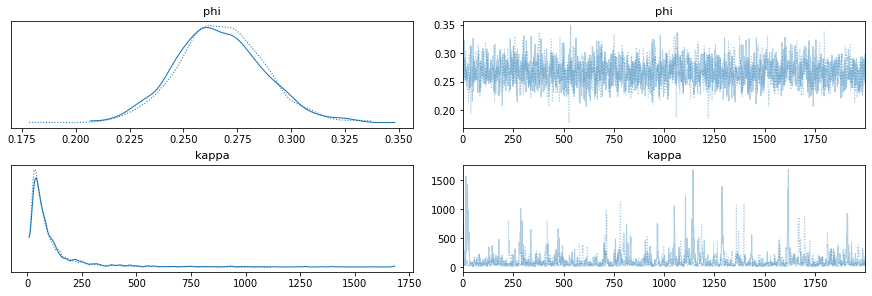

In [7]:
az.plot_trace(trace, var_names = ["phi", "kappa"])

[Text(0, 0.225, 'Roberto Clemente'),
 Text(0, 3.1500000000000004, 'Frank Robinson'),
 Text(0, 6.075000000000001, 'Frank Howard'),
 Text(0, 9.000000000000002, 'Jay Johnstone'),
 Text(0, 11.925, 'Ken Berry'),
 Text(0, 14.85, 'Jim Spencer'),
 Text(0, 17.775, 'Don Kessinger'),
 Text(0, 20.700000000000003, 'Luis Alvarado'),
 Text(0, 23.625, 'Ron Santo'),
 Text(0, 26.550000000000004, 'Ron Swaboda'),
 Text(0, 29.475, 'Rico Petrocelli'),
 Text(0, 32.400000000000006, 'Ellie Rodriguez'),
 Text(0, 35.32500000000001, 'George Scott'),
 Text(0, 38.250000000000014, 'Del Unser'),
 Text(0, 41.17500000000002, 'Billy Williams'),
 Text(0, 44.10000000000002, 'Bert Campaneris'),
 Text(0, 47.02500000000003, 'Thurman Munson'),
 Text(0, 49.95000000000003, 'Max Alvis')]

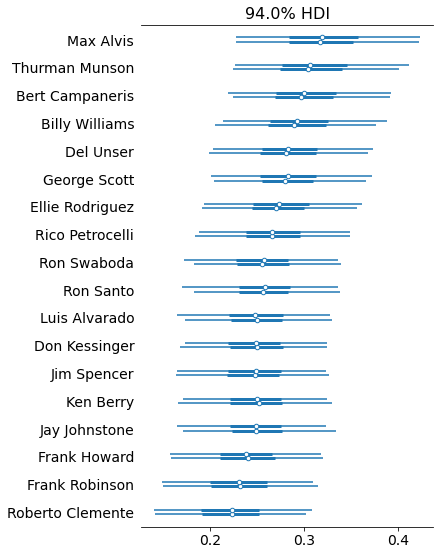

In [10]:
player_names = data.apply(lambda x: x.FirstName + " " + x.LastName, axis = 1)
ax = az.plot_forest(trace, var_names = ["thetas"])
ax[0].set_yticklabels(player_names.tolist())